# Training a model
----
In the previous notebook we noted that our model predictions were un-educated because the model was not trained, the next logical step is to start training the m0d3l's.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

from typing import Tuple

## We need a new file
Up until this point we have been working with a really small data-set. In this notebook we will start training, we need a bit more than 6 lines. Let's create somewhat bigger file with a bunch of randomness in it, it still will not make sense, but will at least help us understand the training concepts.

In [2]:
header = 'Date,Amount,Card,Merchant,MCC,Country,Fraud\n'
file = './data/bigger_card.csv'

MCC_LIST = [f'{i:04d}' for i in range(25)] # Create 25 MCC-Codes
MCC_PROB = list(np.random.random(len(MCC_LIST)))
MCC_PROB = [p/sum(MCC_PROB) for p in MCC_PROB]

Country_LIST = ['FR', 'DE', 'GB', 'NL', 'ES', 'IT', 'SE', 'PL', 'CH'] # Create 9 country codes
Country_PROB = list(np.random.random(len(Country_LIST)))
Country_PROB = [p/sum(Country_PROB) for p in Country_PROB]

Label_LIST = [0,1]
Label_PROB = [0.90, 0.10]

number_of_records = 10000

with open(file, 'w') as f:
    f.write(header)
    for i in range(number_of_records):
        # Dates in range 1st till 30th of January, increasing.
        date = f'202001{int((i/(number_of_records/30))+1):02d}'
        # Random normally distributed amount. Mean 100, stddev 30. Rounded to 2 decimals.
        amount = np.around(np.random.normal(100, 30, 1), 2).item()
        # Create a random card nr 0 to 50
        card_nr = np.random.randint(50)
        # Select an MCC, draw from MCC List accoring to MCC_PROB probability distribution.
        MCC = np.random.choice(MCC_LIST, 1, p=MCC_PROB).item()
        # Select an MCC, draw from Country List accoring to County_PROB probability distribution.
        Country = np.random.choice(Country_LIST, 1, p=Country_PROB).item()
        # Assign some Fraud, this can not be random if we the model to learn something.
        Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0
        # Make row and write.
        row = f'{date},{amount},CARD-{card_nr},MRC-{MCC},{MCC},{Country},{Fraud}\n'
        f.write(row)

Display the first 10 lines of our new file. The layout is the same as the previous file, it just has more lines.

In [3]:
!head -10 $file

Date,Amount,Card,Merchant,MCC,Country,Fraud
20200101,87.54,CARD-28,MRC-0016,0016,DE,0
20200101,68.82,CARD-16,MRC-0013,0013,DE,0
20200101,68.49,CARD-35,MRC-0009,0009,FR,0
20200101,154.42,CARD-23,MRC-0008,0008,DE,0
20200101,83.84,CARD-28,MRC-0005,0005,DE,0
20200101,67.09,CARD-3,MRC-0012,0012,FR,0
20200101,114.69,CARD-47,MRC-0024,0024,ES,0
20200101,120.3,CARD-45,MRC-0011,0011,NL,0
20200101,61.46,CARD-18,MRC-0005,0005,DE,0


## Create our features and data-set

In [4]:
amount   = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
mcc      = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country  = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud    = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_oh        = ft.FeatureOneHot('MCC_OH', ft.FEATURE_TYPE_INT_8,  mcc)
country_oh    = ft.FeatureOneHot('Country_OH', ft.FEATURE_TYPE_INT_8, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_oh     = ft.TensorDefinition('Features_OH', [mcc_oh, country_oh])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_oh, td_amount, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

2023-04-02 12:07:25.889 eng1n3.common.engine           INFO     Start Engine...
2023-04-02 12:07:25.889 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-04-02 12:07:25.890 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-04-02 12:07:25.890 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ./data/bigger_card.csv
2023-04-02 12:07:25.907 e...renormalizescaleprocessor  INFO     Create Scaled_Amount Scale Amount. Min. -6.61 Max. 211.25
2023-04-02 12:07:25.909 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-04-02 12:07:25.911 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays


## Mini-Batches

When we train a model we would not want to loop over the entire data-set. A Neural Net Model is typically optimized on mini-batches of a specific size. In one training step we tend to take a mini-batch number of records, process the mini-batch, calculate the loss, do a backward pass that calculates the gradients, and update the weights.

In order to iterate over a DataSet we wrap it in a 'Torch' `DataLoader`. In this case we allocate the data-set in the computer memory ('cpu') device and we ask for a fairly small batch_size of 32.


In [5]:
# Wrap our DataSets in a Pytorch Dataloader
cpu        = torch.device('cpu')
batch_size = 32

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)

We can now iterate over the DataLoader. Each enumeration will yield a **minibatch** of 3 tensors. By now it should be clear what these 3 are, the OneHot Encoded features, the amount and the label.

Each mini-batch tensor has a size of **(B x F)**, (Batch X Feature). 
- The batch dimension for all tensors is 32 because of our `batch_size`
- The Feature dimension is
    - 34 for the OneHot encoded features, that is 9 countries + 25 MCC codes (from the random file)
    - 1 for the amount feature
    - 1 for the label feature

In [6]:
for i, ds in enumerate(train_dl):
    print(f'--- Iteration {i} -----')
    print(f'{ds[0].shape} {ds[1].shape} {ds[2].shape}')
    if i > 2:
        break

--- Iteration 0 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 1 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 2 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 3 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])


### Sampling and Class-Balance

Generally speaking, one of the bigger challenges in fraud detection in the **class UNbalance**. Neural Nets really need more or less balanced classes in order to train, meaning there is a more or less equal amount of training records for each class (in our case 0, non-fraud and 1 fraud records).

This is never-ever the case in real-life data, there are always more non-fraud records. If we would train with this data, the model would very agressively target predicting the majority (0) class. By default predicting 0 would maybe not even yield that bad of a result.

There are various ways to balance out the classes, one of the simpler techniques is to **oversample** the minority class. I.e. applying a sampling strategy where the 0 minority class has a much bigger probability of being sampled.

In order to oversample our mini-batches we feed a sampler to the data loader construction.

In [7]:
train_sampler = mp.TensorInstanceNumpyLabelSampler(train).over_sampler()

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)

We still get the same number of batches and records, however the sampler changes 2 things.
1. It applies random sampling, this makes sure the same records are not always in the same batch and tends to help generalization.
2. Each mini-batch will now have approx a **50-50** split between class 0 (non-fraud) and class 1 (fraud) records. (Which makes the data balanced)

In [8]:
for i, ds in enumerate(train_dl):
    print(f'--- Iteration {i} -----')
    print(f'{ds[0].shape} {ds[1].shape} {ds[2].shape}')
    if i > 2:
        break

--- Iteration 0 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 1 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 2 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])
--- Iteration 3 -----
torch.Size([32, 34]) torch.Size([32, 1]) torch.Size([32, 1])


## Model

Before we can train a model we obviously need to create one. We'll go with the really simple one again.

In [9]:
class FirstModel(mp.BinaryClassifier):
    def __init__(self, tensor_instance: en.TensorInstanceNumpy):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(FirstModel, self).__init__(tensor_instance)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # One Linear Layer that maps the output of the heads, size 11 to size 1.
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a LIST of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

#Create a 'FirstModel' instance
model = FirstModel(train)
model

FirstModel(
  Number of parameters : 36. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Features_OH, lc=Binary)
    (1): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
  )
  (l1): Linear(in_features=35, out_features=1, bias=True)
  (tail): Sigmoid()
)

## Trainer

Now that we have a `DataLoader` we can use to iterate over the data-set and correctly (over) sample it, we have an `nn.Module` that defines our Neural Net, we can start training it, that is the task of the m0d3l `Trainer`. We feed the trainer, the **model** we want to train, a PyTorch **Device** (CPU or CUDA) and 2 **DataLoader** objects.

The **Trainer** need an optimizer, here we use the AdamW, which is generally a good choice of optimizer. The `lr` parameter defines the learning rate. (More on this later)

And then we can start to train, for instance, run 5 epochs over the data. In each epoch the trainer will
- Run over the training data in chunks of 'batch_size' as defined in the data loader.
- A each step, the loss will be evaluated, and based on the gradients the parameters will be shifted.
- Then the trainer will process the validation file, to see how well the model behaves on the validation file.
- It will end the epoch by updating a 'History' object that keeps track of the performance.

Below we can see an output, because of our ridiculous data-set, this does not make a lot of sense ---yet---. But we see each epoch, how long it took, the training loss and accuracy as well as the validation loss and accuracy.

The **loss** is the measure of how good the predictions are, in this case the `BinaryCrossEntropy` loss and the **accuracy** shows what ratio of records were correctly labelled by the model.

In [10]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.01)
# Run the trainer for 5 epochs
history = trainer.train(5, optimizer)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 1211.04it/s, t_loss=0.0604, t_acc=0.994, v_loss=0.0723, v_acc=0.988]     


After training the trainer outputs a Tuple of `History` objects. Each has a dictionaries with the training and validation metrics respectively

In [11]:
# These are the training metrics.
history[0].history

{'loss': [0.3176, 0.1288, 0.0915, 0.0696, 0.0604],
 'acc': [0.9444, 0.9951, 0.9939, 0.9947, 0.9941]}

In [12]:
# These are the validation metrics.
history[1].history

{'loss': [0.2078, 0.1299, 0.0984, 0.0841, 0.0723],
 'acc': [0.9835, 0.986, 0.986, 0.9875, 0.9875]}

### Training Statistics
That is not so easy to interpret, it's easier to plot them.

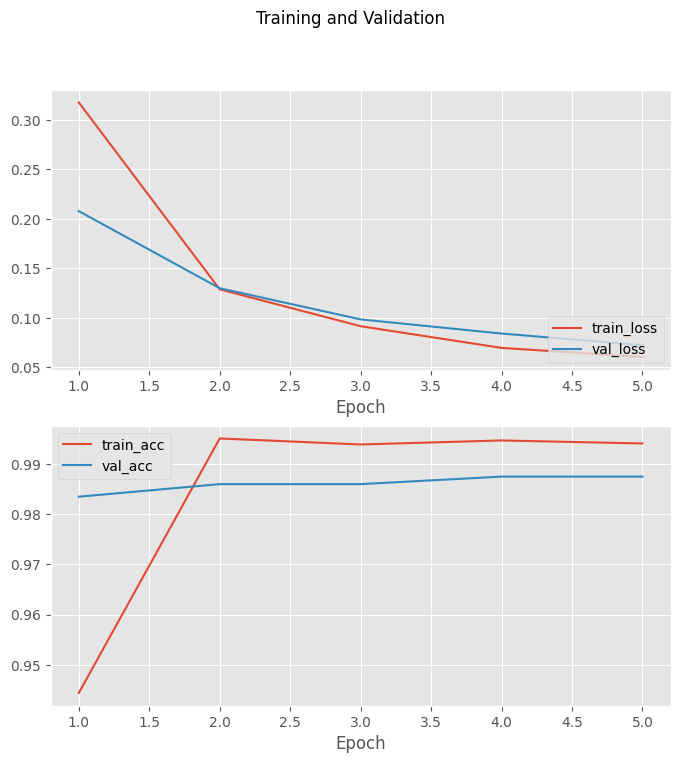

In [13]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

### Overfitting
This sort of plot will become very important for trying to assess when a model is **overfitting**. A model is a situation where a model with a lot of capacity (i.e. a lot of weights) actually manages to **'memorize'** the data instead of **'generalizing'**. It's a bit like studying math, where rather than understanding the rationale of proof (generalizing) one could just try and memorize all the proofs. You'll do great on proof you've seen studying, but might get stuck if you problem is formulated slightly different.

In such case the model does extremely well on training-data, the data it memorizes, but it tends to do bad on the validation data it has not seen during training.

Whenever we see the training loss going down and validation loss going up as we train more epochs, we can get a sense that the model might be overfitting to the data. The fact that in our example the val_acc plateaus is a potential over-fit sign, but the loss still goes down which normally means we're still fairly good.

We have to be slightly careful through. Note that our training data has been **over sampled**, it has an equal amount fraud vs non-fraud, and the validation data has **not been over sampled**, it has more non-fraud than fraud. 

Some people prefer the 2 data-sets to have an equal 'balance', that is easier to spot overfitting, because then, as soon as the validation loss starts being bigger than the training loss and diverges, we are overfitting. Down size of having an equal balance is that the validation set no longer reflects the expected result of the test set. Which could potentially lead to surprises. For instance a model that is proportionally better at catching fraud will do well and over sampled validation set, but might create a ton of false postives on the testing set.

### Finding the Learning Rate
One of the most important parameters to tune in a Neural Net is the Learning Rate. The learning rate is the rate which the weights in the model are updated after each step, based on the gradient. If it is too low the learning can be slow and the model could get stuck in a local minimum. If it is too high the learning result will be all over the place, the accuracy and loss will bounce up and down fairly wildly. 

One fairly simple way to find a decent learning rate is to process the first x set of mini-batches in a file, starting with a small learning rate and gradually increasing it. Normally that will show a plot where initially the loss does not decrease, after a while it starts decreasing, plateaus, and often then explodes upward. A good learning rate tends to be a little after we start decending. For our case, it seems like we can probably get away with a slightly higher learning rate, which would make us converge faster, 1e-1 might still be OK.

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 1100.47it/s]                                                   


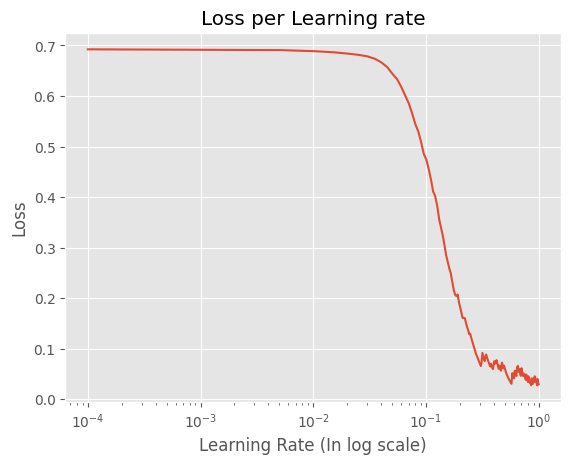

In [14]:
min_lr = 1e-4 
max_lr = 1
m_lr = FirstModel(train)
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, torch.device('cpu'), train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Using a schedule to adjust the learning rate.
When we are training a model we will quite often not just to have one single Learning rate for the trainging loop, we may want to adjust it as we go along.

PyTorch offers **step** schedulers that can dynamically adjust the learning rate. The Pytorch documentation has more info here; https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate.

One schedule that seems to work fairly well on relatively simple Neural Nets is the OneCycle training as proposed by [Leslie N. Smith, A DISCIPLINED APPROACH TO NEURAL NETWORK HYPER-PARAMETERS](https://arxiv.org/pdf/1803.09820.pdf). This scheduler will gradually build up the learning rate towards a maximum learning rate and then decrease it towards the end of the training cycle.

In [15]:
EPOCHS = 5
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
optimizer = mp.AdamWOptimizer(model, lr=0.01)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)
# Feed the scheduler to the trainer.
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 282/282 [00:00<00:00, 1094.67it/s, t_loss=0.0359, t_acc=0.994, v_loss=0.0534, v_acc=0.989]     


This training schedule tends to make the loss and accuracy jump around a bit toward the middle of the training cycle, but it tends to land in a better place than a fixed schedule.

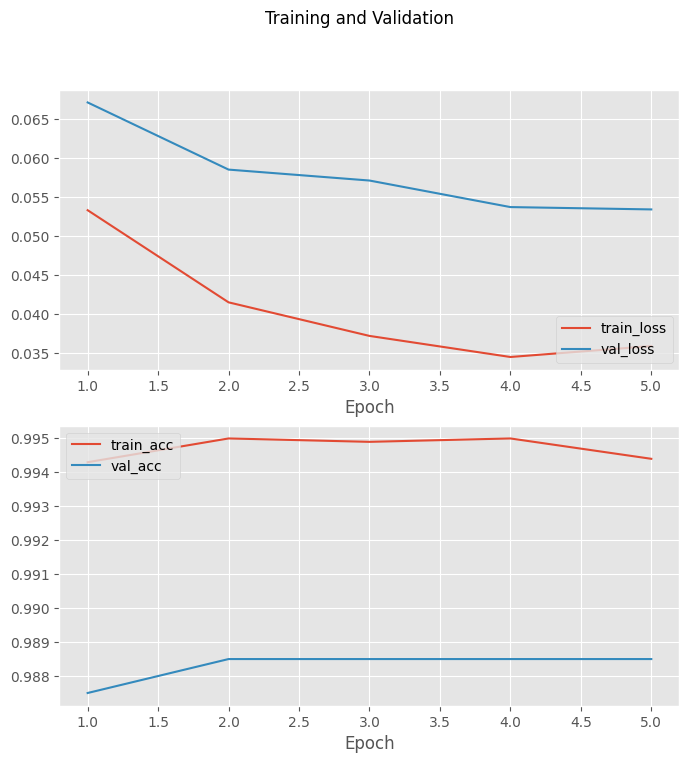

In [16]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

Clean-up after ourselves. Delete our test file.

In [17]:
!rm $file

## Conclusion
We trained our first Neural Net on some data that does not really make a lot of sense. But it showed us how to use mini-batches, how to monitor overfitting and a simple way to find an initial learning-rate.